# Proiect Procesarea Semnalelor
# Glodea Eusebiu, 342C2

## Importuri necesare si pregatirea setului de date pentru lucru

In [43]:
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.signal import butter, lfilter, filtfilt
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import os
import librosa


wav_dir = "/content/signals"
wav_dir2 = "/content/testing"
os.makedirs(wav_dir, exist_ok=True)
os.makedirs(wav_dir2, exist_ok=True)


In [27]:
dataset = []

for file_name in os.listdir(wav_dir):
    if file_name.endswith(".wav"):
        file_path = os.path.join(wav_dir, file_name)

        signal, sr = librosa.load(file_path, sr=None)

        dataset.append({
            "file_name": file_name,
            "signal": signal,
            "sampling_rate": sr,
            "duration": len(signal) / sr
        })

testing_data = []

for file_name in os.listdir(wav_dir2):
    if file_name.endswith(".wav"):
        file_path = os.path.join(wav_dir2, file_name)

        signal, sr = librosa.load(file_path, sr=None)

        testing_data.append({
            "file_name": file_name,
            "signal": signal,
            "sampling_rate": sr,
            "duration": len(signal) / sr
        })

In [11]:
# print(dataset)
# print(testing_data)

## Afisarea semnalelor in domeniul timpului

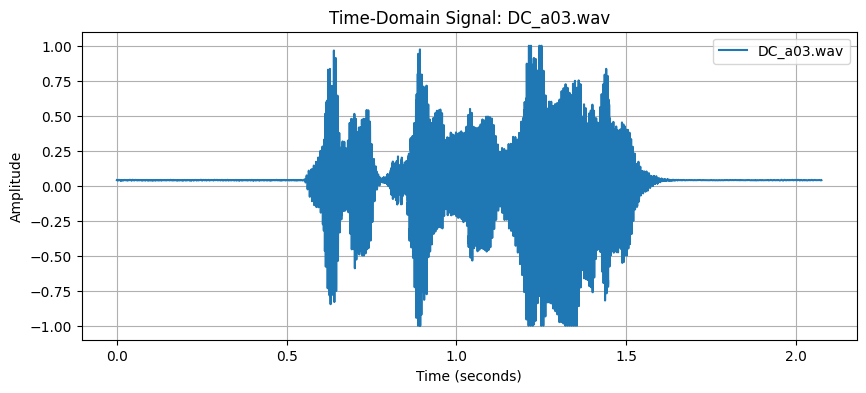

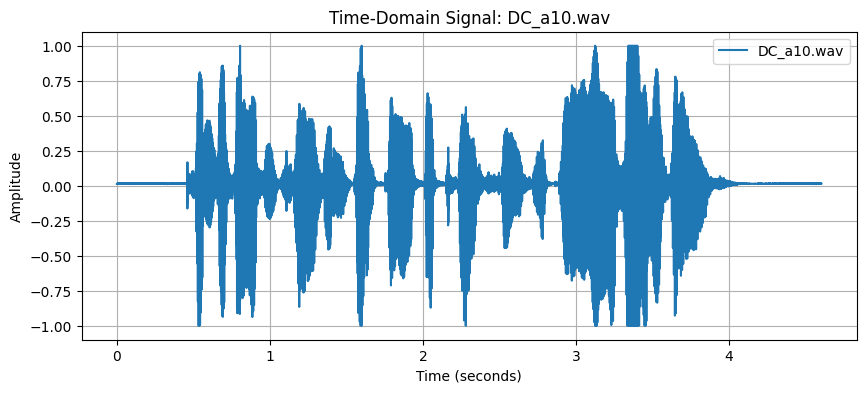

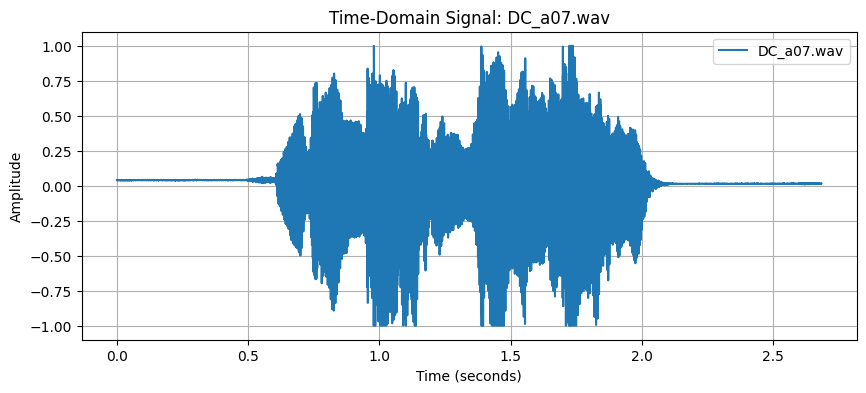

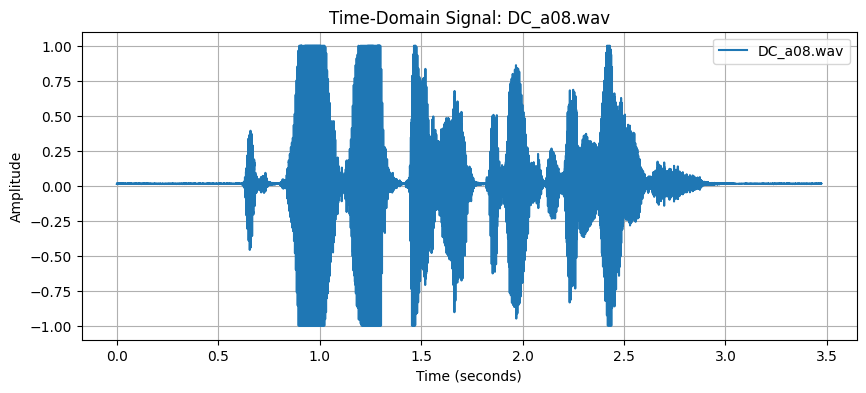

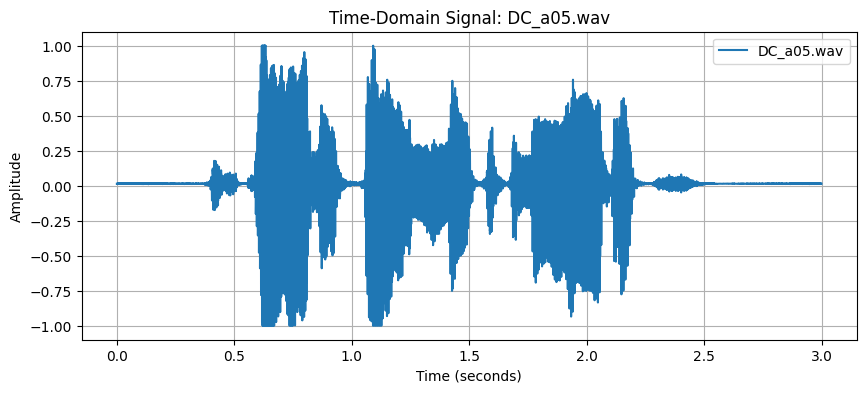

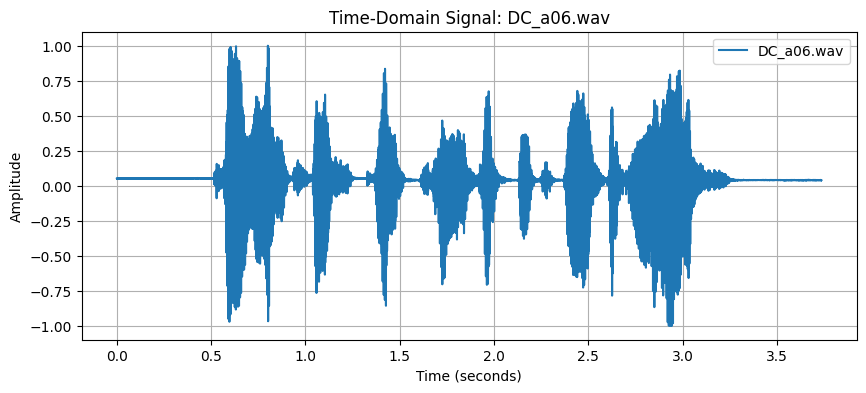

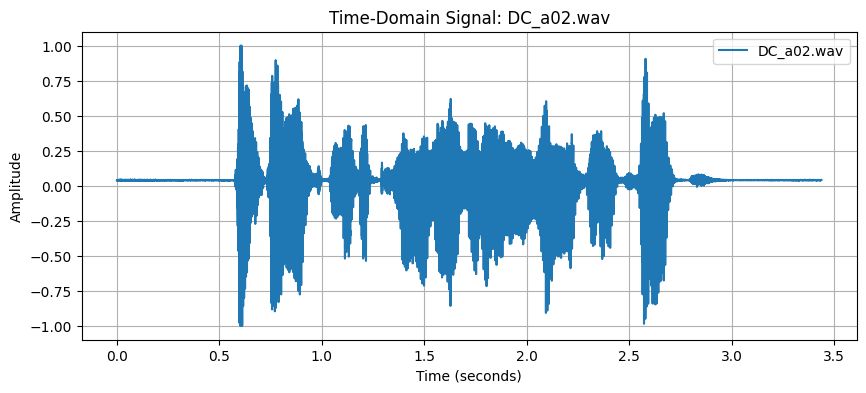

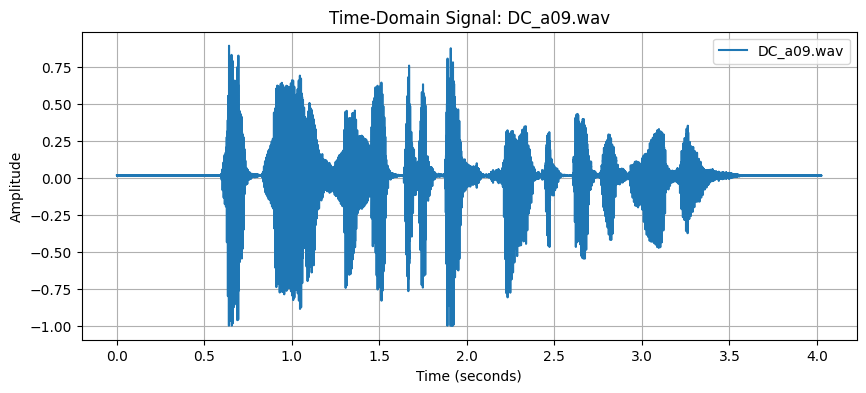

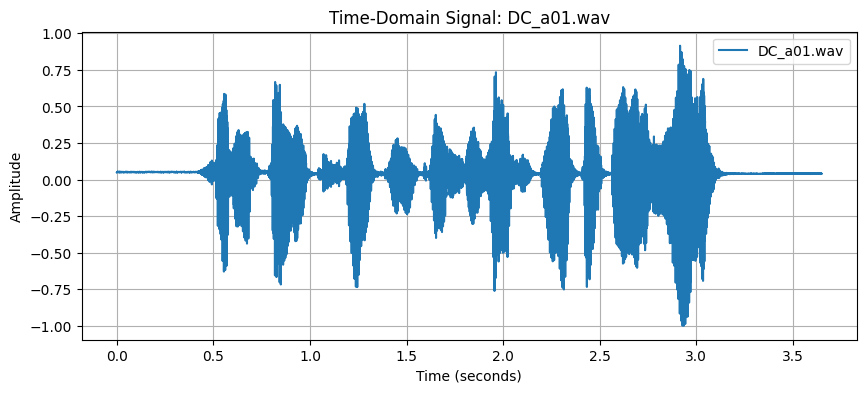

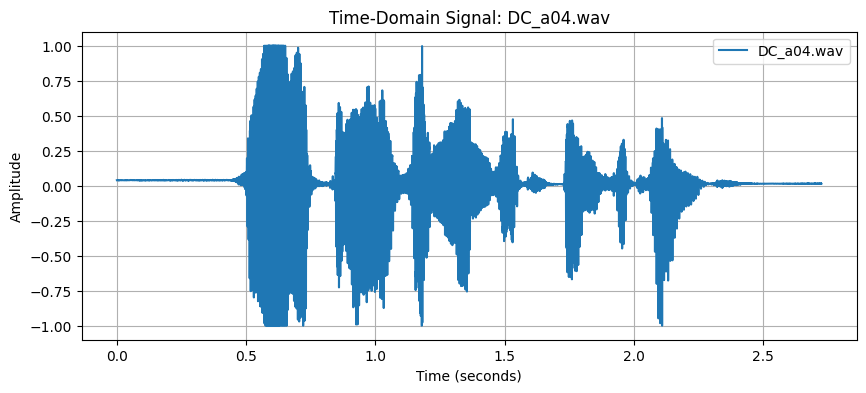

In [28]:
for data in dataset:
    file_name = data['file_name']
    signal = data['signal']
    sampling_rate = data['sampling_rate']

    time = np.linspace(0, len(signal) / sampling_rate, num=len(signal))

    plt.figure(figsize=(10, 4))
    plt.plot(time, signal, label=file_name)
    plt.title(f"Time-Domain Signal: {file_name}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend(loc="upper right")
    plt.grid()
    plt.show()

## Aplicarea unui filtru trece-jos pe semnale

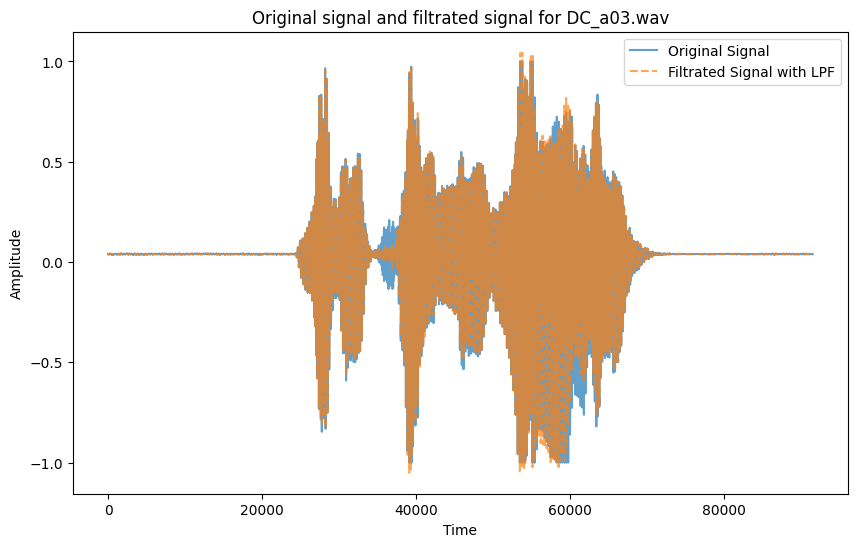

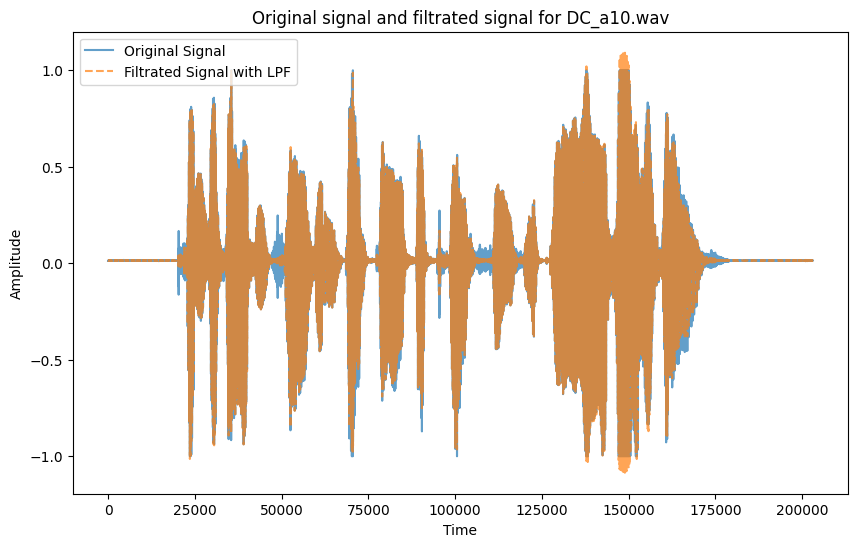

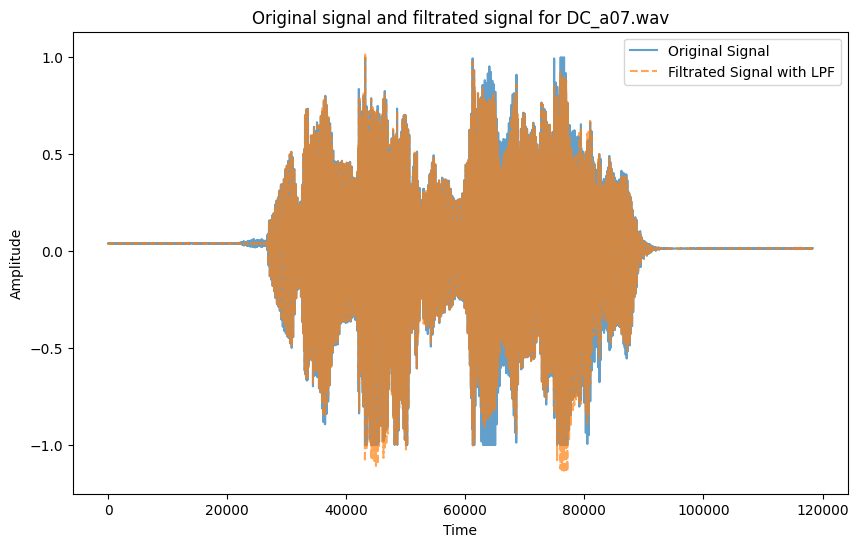

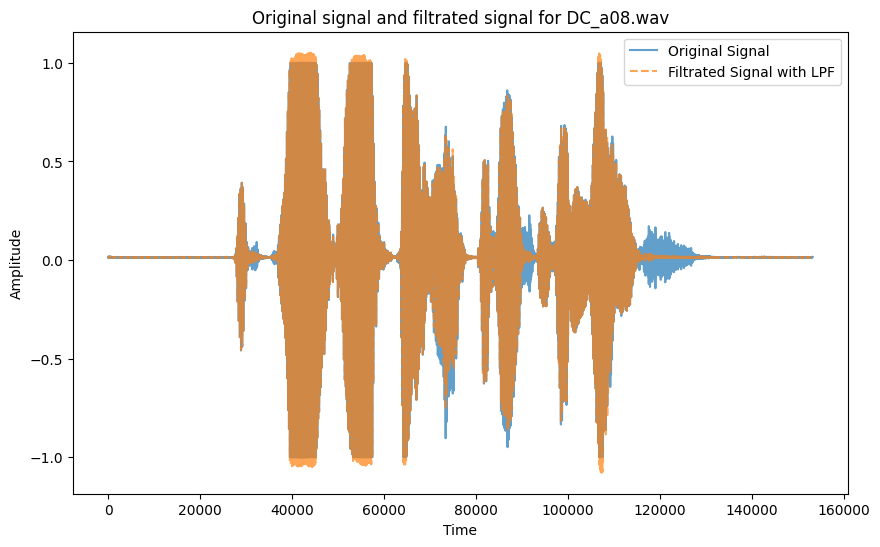

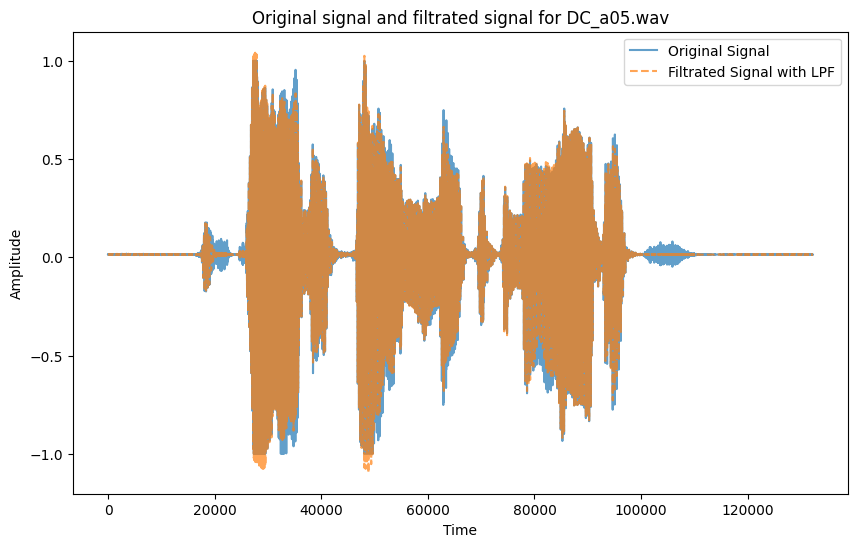

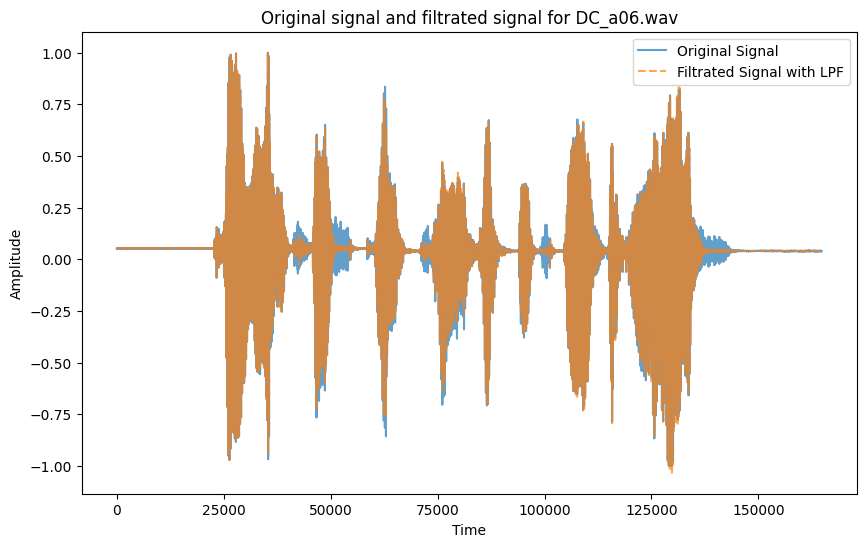

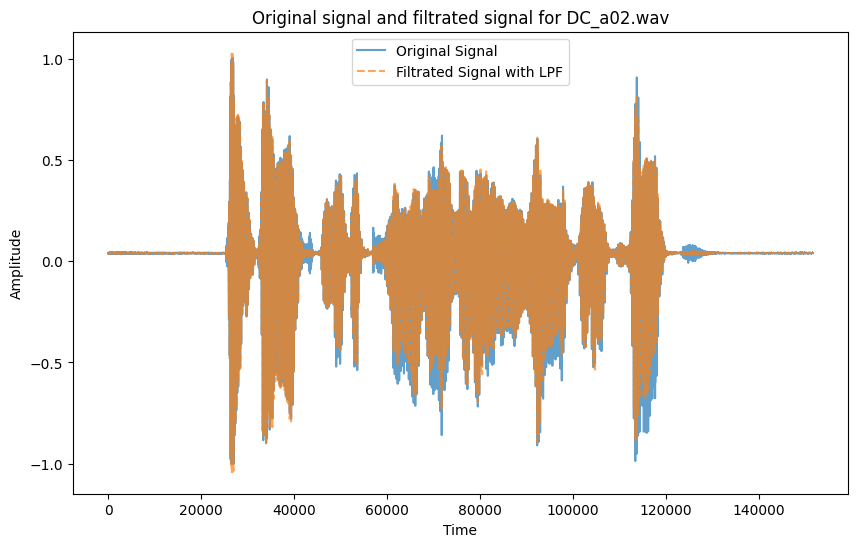

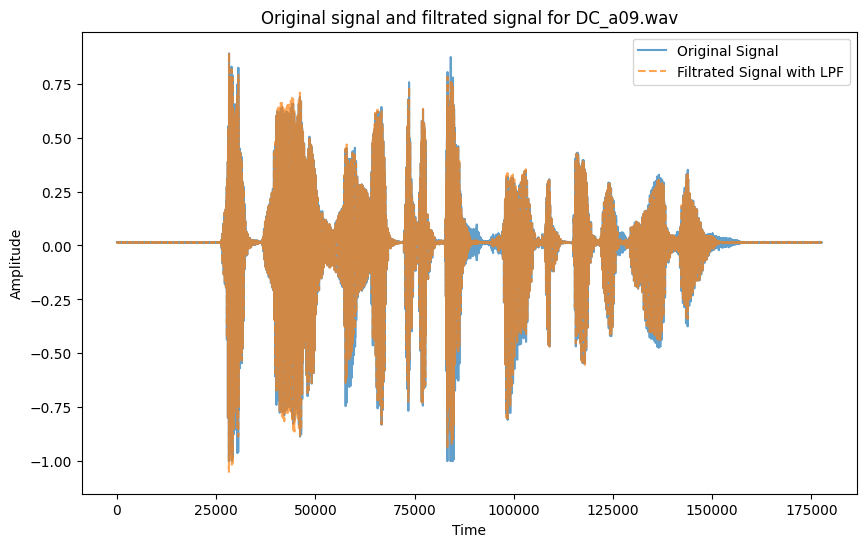

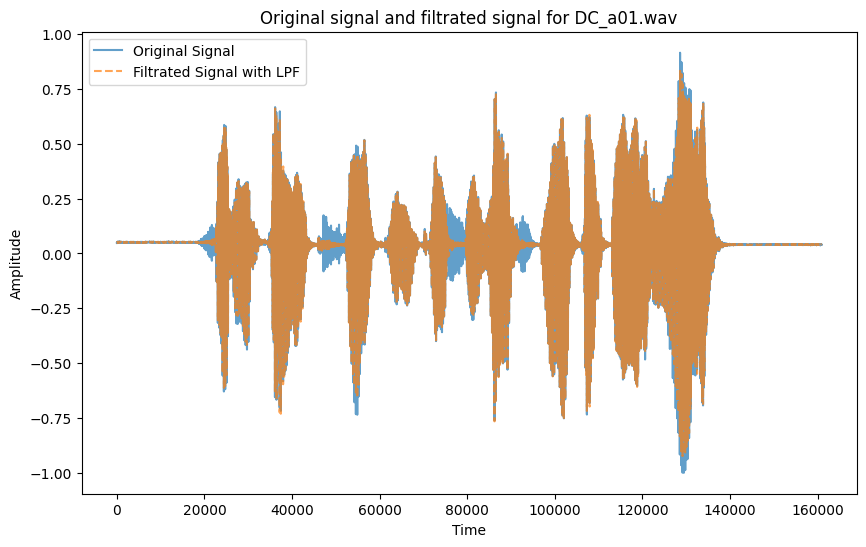

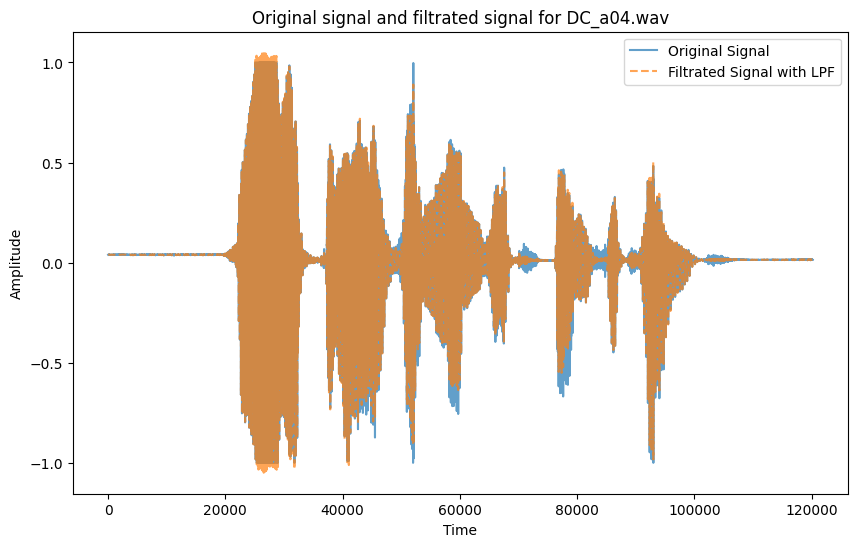

In [29]:
def low_pass_filter(signal, cutoff_freq, sample_rate, order=4):
    nyquist_freq = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist_freq

    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    filtered_signal = filtfilt(b, a, signal)

    return filtered_signal

cutoff_freq = 2000
order = 4

for data in dataset:
    file_name = data['file_name']
    signal = data['signal']
    sampling_rate = data['sampling_rate']

    filtered_signal = low_pass_filter(signal, cutoff_freq, sampling_rate, order)

    data['filtered_signal'] = filtered_signal

    plt.figure(figsize=(10, 6))
    plt.plot(signal, label='Original Signal', alpha=0.7)
    plt.plot(filtered_signal, label='Filtrated Signal with LPF', linestyle='--', alpha=0.7)
    plt.title(f"Original signal and filtrated signal for {file_name}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()



## Trecerea semnalelor din domeniul timpului in cel al frecventei

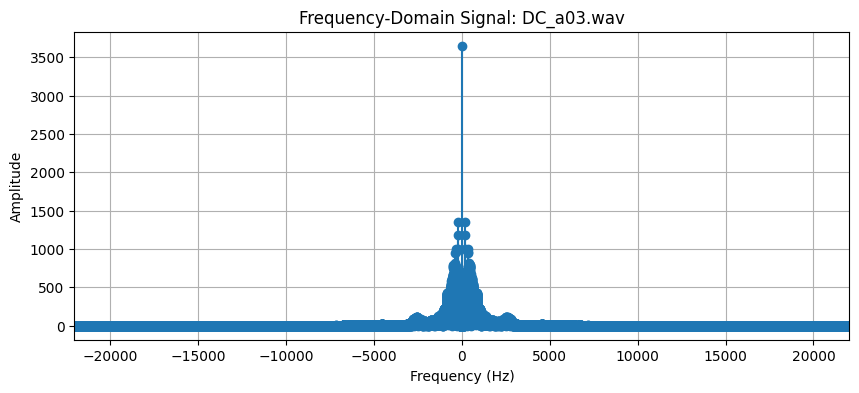

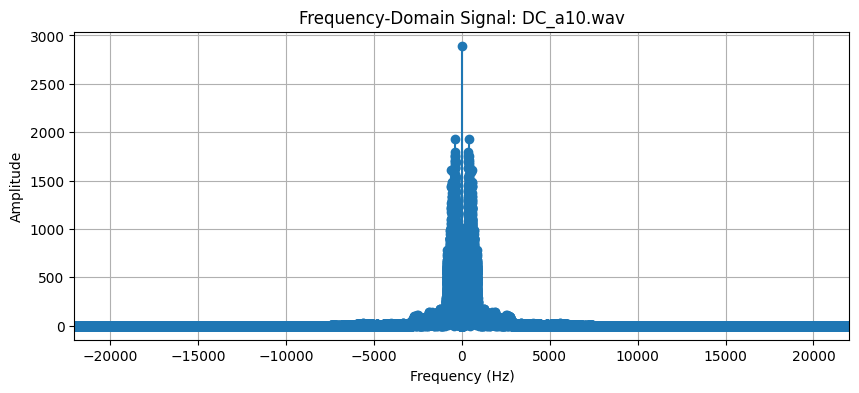

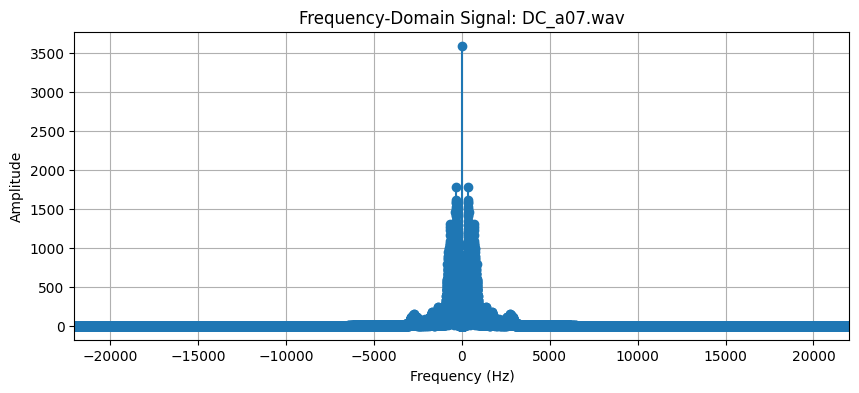

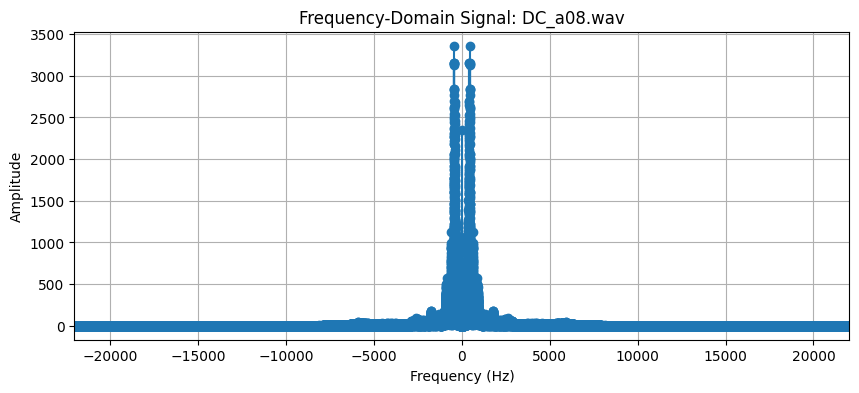

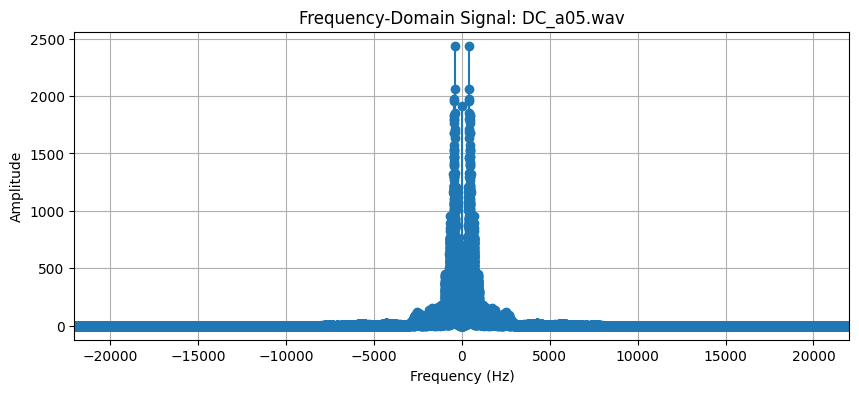

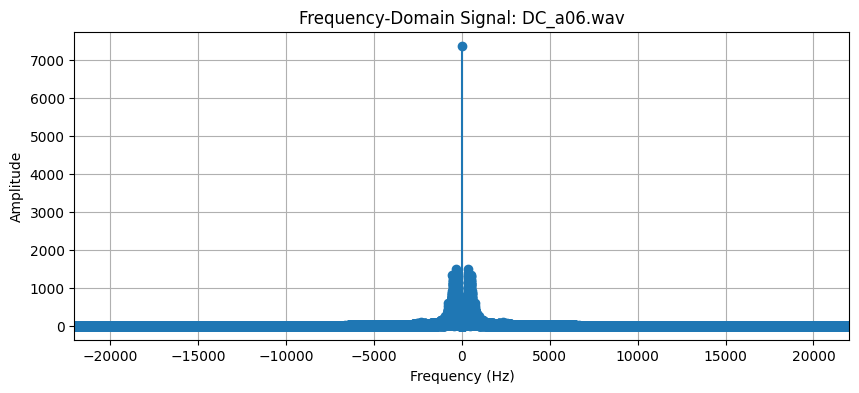

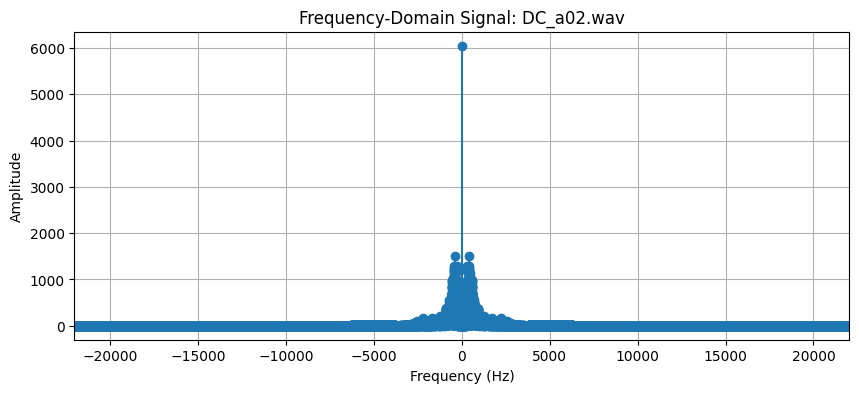

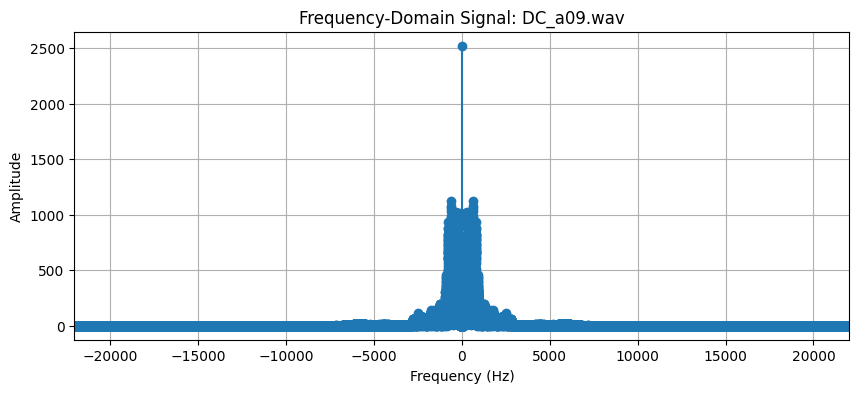

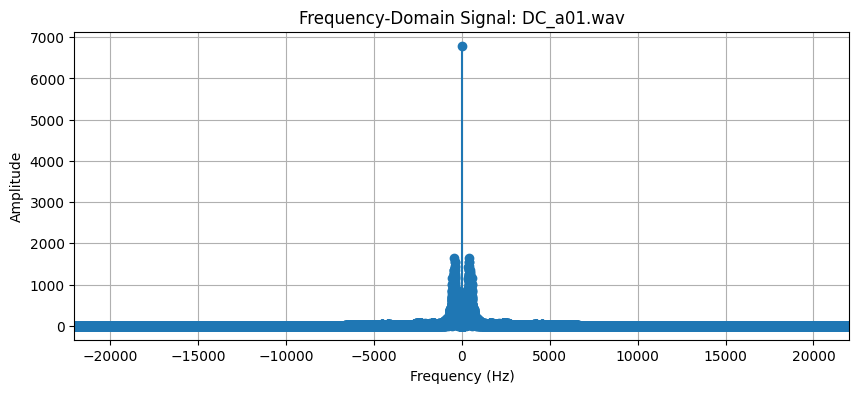

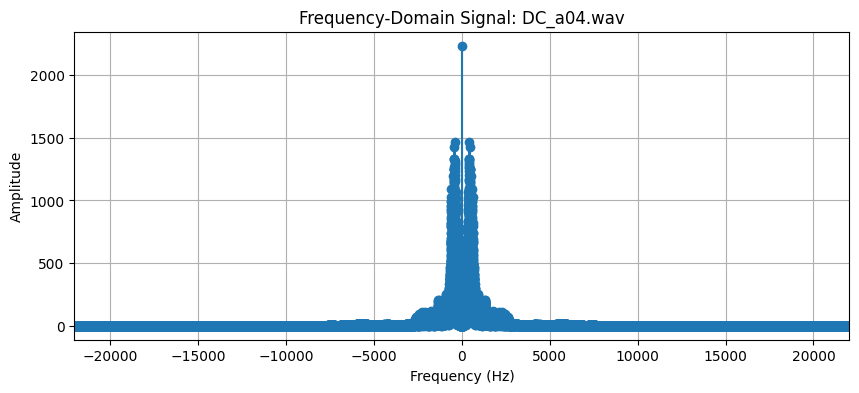

In [30]:
for data in dataset:
    file_name = data['file_name']
    signal = data['signal']
    sampling_rate = data['sampling_rate']

    fft_result = np.fft.fft(signal)
    fft_magnitude = np.abs(fft_result)
    fft_freqs = np.fft.fftfreq(len(signal), d=1/sampling_rate)

    plt.figure(figsize=(10, 4))
    plt.stem(fft_freqs, fft_magnitude, basefmt=" ")
    plt.title(f"Frequency-Domain Signal: {file_name}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.xlim(-sampling_rate / 2, sampling_rate / 2)
    plt.show()

## Trecerea semnalelor in domeniul timp-frecventa

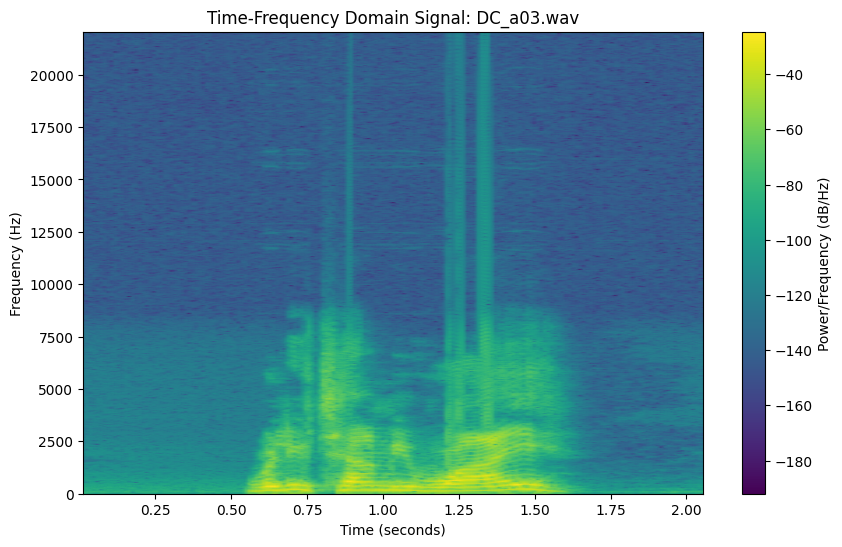

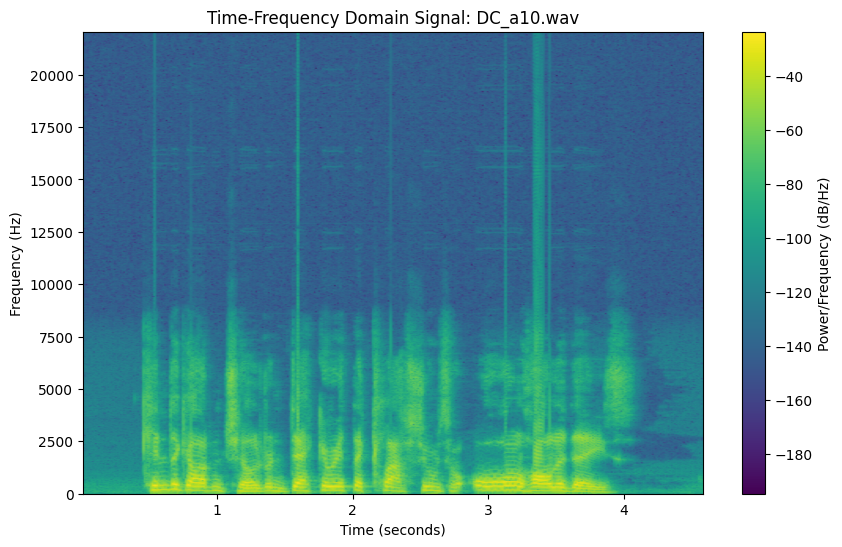

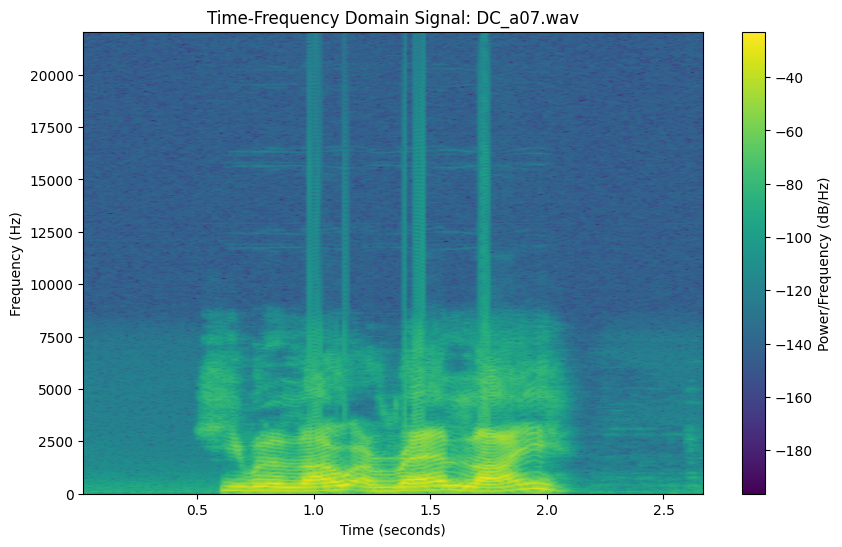

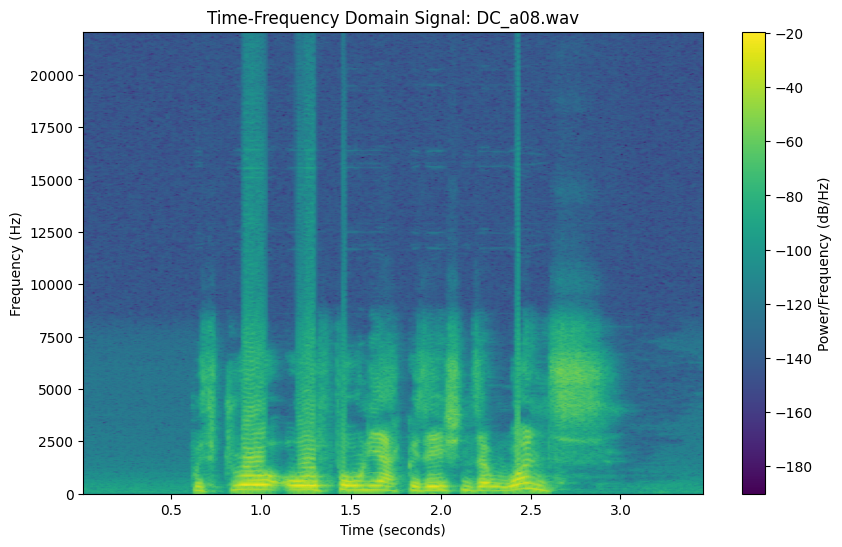

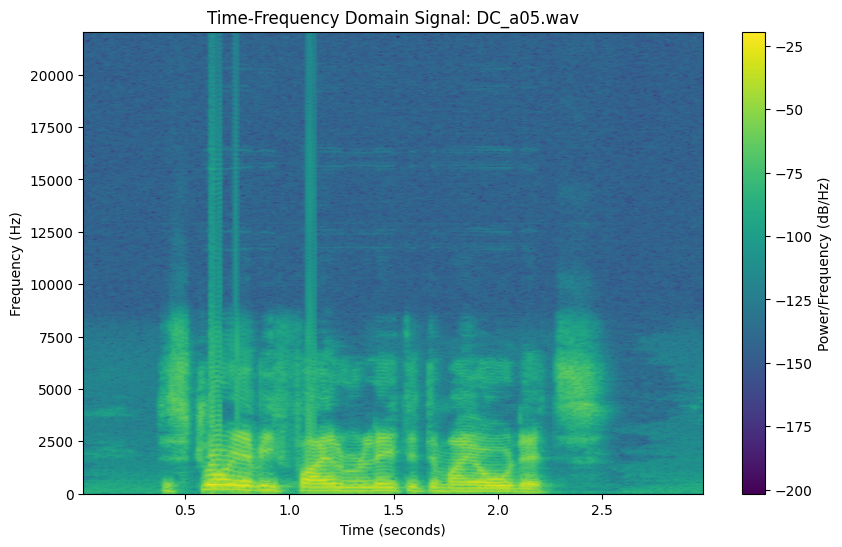

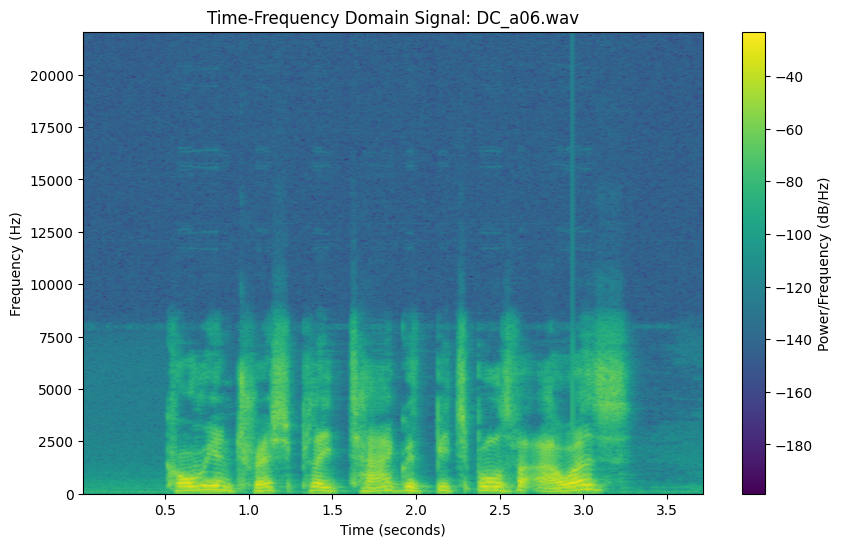

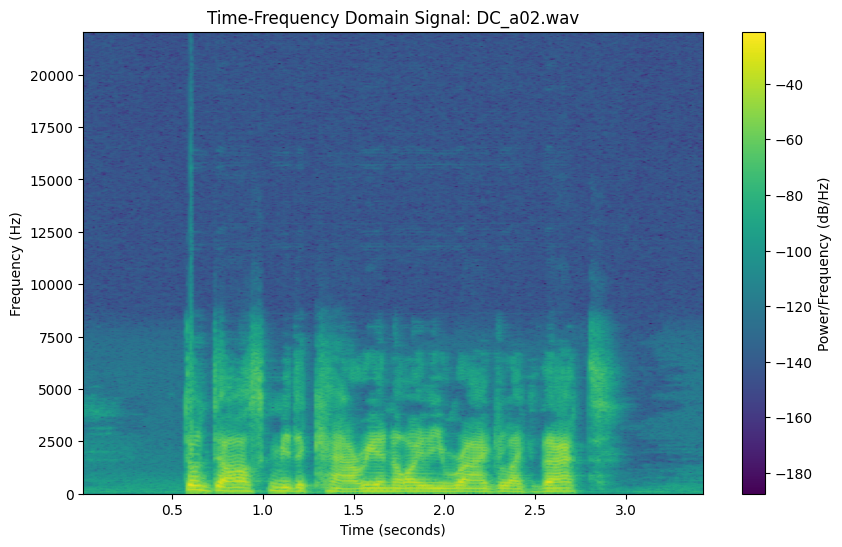

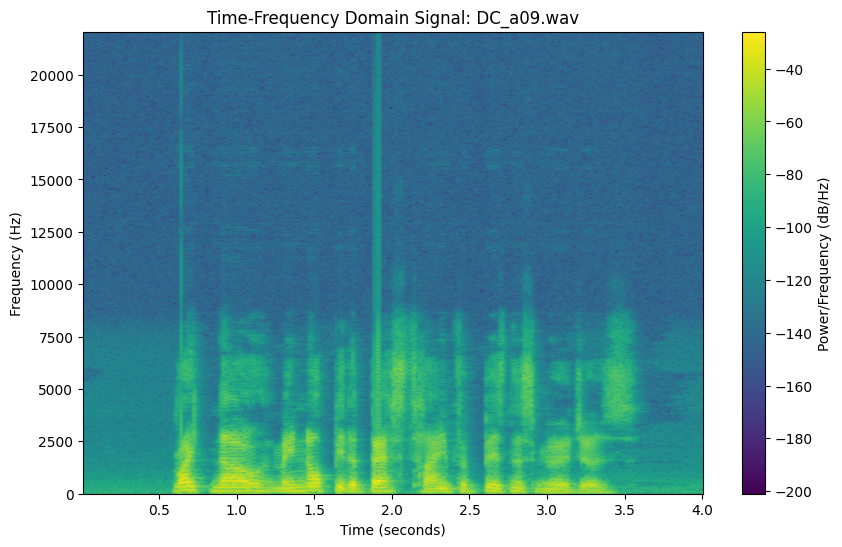

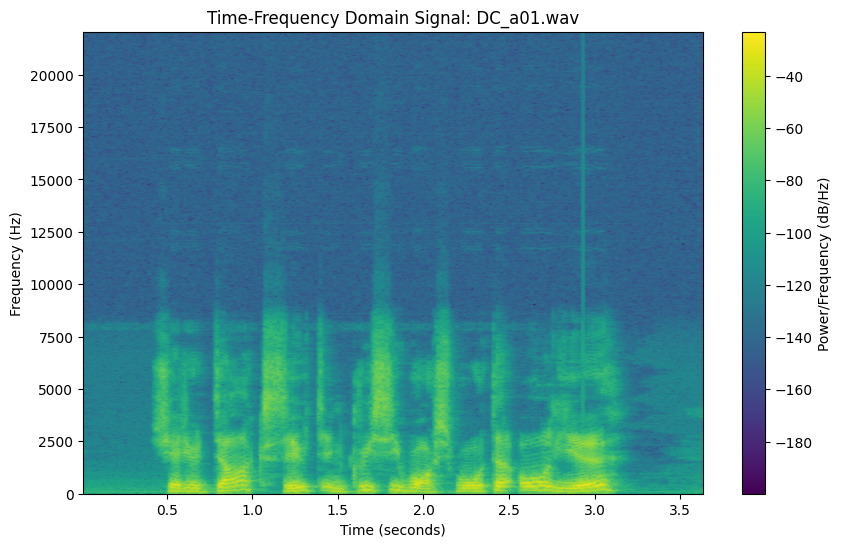

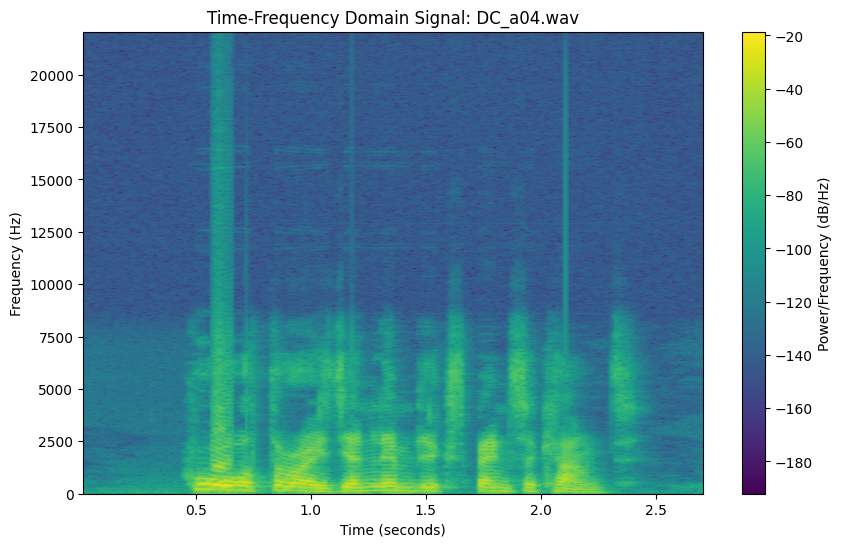

In [31]:
for data in dataset:
    file_name = data['file_name']
    signal = data['signal']
    sampling_rate = data['sampling_rate']

    f, t, Sxx = spectrogram(signal, fs=sampling_rate, nperseg=1024, noverlap=512)

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.title(f"Time-Frequency Domain Signal: {file_name}")
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (seconds)')
    plt.colorbar(label='Power/Frequency (dB/Hz)')
    plt.ylim(0, sampling_rate / 2)
    plt.show()



## Analiza energiei din cele 3 tipuri de domenii

In [32]:
def calculate_energy_time_domain(signal):
    return np.sum(signal ** 2)

def calculate_energy_frequency_domain(fft_magnitude):
    return np.sum(fft_magnitude ** 2)

def calculate_energy_time_frequency_domain(Sxx):
    return np.sum(Sxx)

for data in dataset:
    file_name = data['file_name']
    signal = data['signal']
    sampling_rate = data['sampling_rate']

    energy_time_domain = calculate_energy_time_domain(signal)

    fft_result = fft(signal)
    fft_magnitude = np.abs(fft_result[:len(fft_result)//2])
    energy_frequency_domain = calculate_energy_frequency_domain(fft_magnitude)

    f, t, Sxx = spectrogram(signal, sampling_rate)
    energy_time_frequency_domain = calculate_energy_time_frequency_domain(Sxx)

    print(f"Results for {file_name}:")
    print(f"Energy in Time Domain: {energy_time_domain:.4f}")
    print(f"Energy in Frequency Domain: {energy_frequency_domain:.4f}")
    print(f"Energy in Time-Frequency Domain: {energy_time_frequency_domain:.4f}")
    print("-" * 50)

Results for DC_a03.wav:
Energy in Time Domain: 3652.5764
Energy in Frequency Domain: 173825808.0000
Energy in Time-Frequency Domain: 0.0912
--------------------------------------------------
Results for DC_a10.wav:
Energy in Time Domain: 9587.4717
Energy in Frequency Domain: 977549632.0000
Energy in Time-Frequency Domain: 0.2482
--------------------------------------------------
Results for DC_a07.wav:
Energy in Time Domain: 7554.2910
Energy in Frequency Domain: 453492608.0000
Energy in Time-Frequency Domain: 0.1929
--------------------------------------------------
Results for DC_a08.wav:
Energy in Time Domain: 10683.6611
Energy in Frequency Domain: 820908608.0000
Energy in Time-Frequency Domain: 0.2777
--------------------------------------------------
Results for DC_a05.wav:
Energy in Time Domain: 6315.4375
Energy in Frequency Domain: 419308608.0000
Energy in Time-Frequency Domain: 0.1627
--------------------------------------------------
Results for DC_a06.wav:
Energy in Time Domai

## Utilizarea si analiza metricii SNR pentru cele 3 tipuri de domenii

In [47]:
def snr_time_domain(signal, noise_level):
    signal_power = np.mean(signal**2)
    noise_power = noise_level**2
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

def snr_frequency_domain(signal, sample_rate, noise_level):
    fft_result = fft(signal)
    fft_magnitude = np.abs(fft_result[:len(fft_result)//2])
    frequencies = fftfreq(len(signal), 1 / sample_rate)[:len(fft_result)//2]

    signal_energy = np.sum(fft_magnitude[frequencies < 200]**2)
    noise_energy = noise_level**2 * len(fft_magnitude)
    snr = 10 * np.log10(signal_energy / noise_energy)
    return snr

def snr_time_frequency(signal, sample_rate, noise_level, time_window, freq_window, epsilon=1e-10):
    f, t, Sxx = spectrogram(signal, sample_rate)

    time_indices = (t >= time_window[0]) & (t <= time_window[1])
    freq_indices = (f >= freq_window[0]) & (f <= freq_window[1])
    signal_energy = np.sum(Sxx[freq_indices, :][:, time_indices])

    noise_mask = ~freq_indices
    noise_energy = np.mean(Sxx[noise_mask]) * np.sum(Sxx.size)

    signal_energy = signal_energy + epsilon
    noise_energy = noise_energy + epsilon

    snr = 10 * np.log10(signal_energy / noise_energy)
    return snr

noise_level = 0.2

default_time_window = (0.1, 0.2)
default_freq_window = (50, 55)

for data in dataset:
    file_name = data['file_name']
    signal = data['signal']
    sampling_rate = data['sampling_rate']

    if file_name == 'DC_a01.wav':
        time_window = (0.3, 3.0)
        freq_window = (0, 7500)
    elif file_name == 'DC_a02.wav':
        time_window = (0.55, 2.85)
        freq_window = (0, 8000)
    elif file_name == 'DC_a03.wav':
        time_window = (0.55, 1.55)
        freq_window = (0, 8000)
    elif file_name == 'DC_a04.wav':
        time_window = (0.45, 2.4)
        freq_window = (0, 8000)
    elif file_name == 'DC_a05.wav':
        time_window = (0.4, 2.5)
        freq_window = (0, 8500)
    elif file_name == 'DC_a06.wav':
        time_window = (0.5, 3.25)
        freq_window = (0, 8500)
    elif file_name == 'DC_a07.wav':
        time_window = (0.5, 2.05)
        freq_window = (0, 8500)
    elif file_name == 'DC_a08.wav':
        time_window = (0.6, 2.9)
        freq_window = (0, 8500)
    elif file_name == 'DC_a09.wav':
        time_window = (0.5, 3.55)
        freq_window = (0, 8500)
    elif file_name == 'DC_a10.wav':
        time_window = (0.0, 4.0)
        freq_window = (0, 8500)
    else:
        time_window = default_time_window
        freq_window = default_freq_window

    snr_time = snr_time_domain(signal, noise_level)
    snr_freq = snr_frequency_domain(signal, sampling_rate, noise_level)
    snr_tf = snr_time_frequency(signal, sampling_rate, noise_level, time_window, freq_window)

    print(f"Results for {file_name}:")
    print(f"SNR in the time domain: {snr_time:.2f} dB")
    print(f"SNR in the frequency domain: {snr_freq:.2f} dB")
    print(f"SNR in the time-frequency domain: {snr_tf:.2f} dB")
    print("-" * 50)


Results for DC_a03.wav:
SNR in the time domain: -0.01 dB
SNR in the frequency domain: 42.01 dB
SNR in the time-frequency domain: 58.59 dB
--------------------------------------------------
Results for DC_a10.wav:
SNR in the time domain: 0.72 dB
SNR in the frequency domain: 41.91 dB
SNR in the time-frequency domain: 61.98 dB
--------------------------------------------------
Results for DC_a07.wav:
SNR in the time domain: 2.03 dB
SNR in the frequency domain: 41.40 dB
SNR in the time-frequency domain: 61.41 dB
--------------------------------------------------
Results for DC_a08.wav:
SNR in the time domain: 2.42 dB
SNR in the frequency domain: 38.42 dB
SNR in the time-frequency domain: 57.77 dB
--------------------------------------------------
Results for DC_a05.wav:
SNR in the time domain: 0.77 dB
SNR in the frequency domain: 38.39 dB
SNR in the time-frequency domain: 61.55 dB
--------------------------------------------------
Results for DC_a06.wav:
SNR in the time domain: -1.24 dB
SN

## Crearea si aplicarea unui algoritm de clasificare pentru semnalele din domeniul timp-frecventa bazat pe o valoare prag a SNR

In [49]:
for data in testing_data:
    file_name = data['file_name']
    signal = data['signal']
    sampling_rate = data['sampling_rate']

    filtered_signal = low_pass_filter(signal, cutoff_freq, sampling_rate, order)

    data['filtered_signal'] = filtered_signal

for data in testing_data:
    file_name = data['file_name']
    signal = data['signal']
    sampling_rate = data['sampling_rate']

    f, t, Sxx = spectrogram(signal, fs=sampling_rate, nperseg=1024, noverlap=512)



In [50]:
def extract_features_and_labels_with_snr(data, labels=None, snr_params=None):
    features = []
    for entry in data:
        signal = entry['filtered_signal']
        sampling_rate = entry['sampling_rate']

        mfcc = librosa.feature.mfcc(y=signal, sr=sampling_rate, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)

        time_window = snr_params['time_window']
        freq_window = snr_params['freq_window']
        noise_level = snr_params['noise_level']
        snr = snr_time_frequency(signal, sampling_rate, noise_level, time_window, freq_window)

        feature_vector = np.append(mfcc_mean, snr)
        features.append(feature_vector)

    features = np.array(features)
    if labels is not None:
        return features, np.array(labels)
    return features

snr_params = {
    'time_window': (0.0, 1.0),
    'freq_window': (300, 3000),
    'noise_level': 0.1
}

labels = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

X_train, y_train = extract_features_and_labels_with_snr(dataset, labels, snr_params)
X_test = extract_features_and_labels_with_snr(testing_data, snr_params=snr_params)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
true_labels = [0, 1, 0, 1, 0, 1, 0, 1, 0, 1]

print(classification_report(true_labels, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.83      1.00      0.91         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10

